In [2]:
import numpy as np
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max(
            )
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [29]:
df_train = pd.read_csv('C:/Users/user/Documents/Salamat/ELO/train.csv')
df_test = pd.read_csv('C:/Users/user/Documents/Salamat/ELO/test.csv')
# df_hist_trans = pd.read_csv('C:/Users/user/Documents/Salamat/ELO/historical_transactions.csv')
# df_new_merchant_trans = pd.read_csv('C:/Users/user/Documents/Salamat/ELO/new_merchant_transactions.csv')

In [4]:
df_train=reduce_mem_usage(df_train)
df_test=reduce_mem_usage(df_test)
df_hist_trans=reduce_mem_usage(df_hist_trans)
df_new_merchant_trans=reduce_mem_usage(df_new_merchant_trans)

Mem. usage decreased to  4.04 Mb (56.2% reduction)
Mem. usage decreased to  2.24 Mb (52.5% reduction)
Mem. usage decreased to 1749.11 Mb (43.7% reduction)
Mem. usage decreased to 114.20 Mb (45.5% reduction)


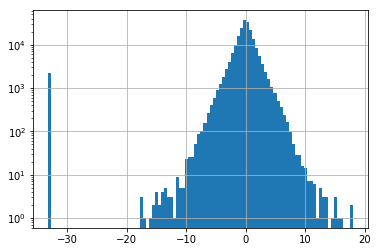

In [9]:
plt.figure()
df_train.target.hist(bins=100)
plt.yscale('log')

In [21]:
index_out=df_train[df_train.target<-30].card_id.values

In [28]:
index_out.shape

(2207,)

In [31]:
print("Percentage of outliers in provided data")
print(index_out.shape[0]/df_train.shape[0]*100)

Percentage of outliers in provided data
1.0930233709890698


In [ ]:
df_hist_trans
df_new_merchant_trans

In [27]:
df_hist_trans[df_hist_trans.card_id.isin(index_out)].shape

(180105, 14)

In [39]:
hist_out=df_hist_trans[df_hist_trans.card_id.isin(index_out)]

In [44]:
hist_out.state_id.value_counts()

 9     53712
-1     37040
 15    13728
 16    12148
 22     6971
 5      6937
 19     5832
 4      5308
 20     5164
 13     4404
 11     3864
 21     3763
 3      3699
 12     2990
 24     2462
 7      2222
 2      1982
 18     1649
 10     1602
 8      1136
 23     1019
 14      959
 1       812
 17      668
 6        34
Name: state_id, dtype: int64

In [57]:
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
df_train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [59]:
df_train[df_train['outliers']==1].target.unique()

array([-33.21928095])

In [61]:
df_train[df_train['outliers']==0].target.max()

17.9650684

In [62]:
df_train[df_train['outliers']==0].target.min()

-17.608146510000001

In [63]:
df_train['outliers'].corr(df_train['feature_1'])

0.010544299051383967

In [64]:
df_train['outliers'].corr(df_train['feature_2'])

0.0051907081306825312

In [65]:
df_train['outliers'].corr(df_train['feature_3'])

0.0054570917423288953

In [66]:
 order_label = df_train.groupby(['feature_1'])['outliers'].mean()

In [67]:
order_label

feature_1
1    0.008058
2    0.010610
3    0.010479
4    0.010712
5    0.013145
Name: outliers, dtype: float64

In [49]:
for f in ['feature_1','feature_2','feature_3']:
    order_label = df_train.groupby([f])['outliers'].mean()
    df_train[f] = df_train[f].map(order_label)
    df_test[f] = df_test[f].map(order_label)

In [54]:
df_train[df_train['outliers']==0]

,first_active_month,card_id,feature_1,feature_2,feature_3,target,outliers
0,2017-06,C_ID_92a2005557,0.013145,0.008752,0.011428,-0.820312,0
1,2017-01,C_ID_3d0044924f,0.010712,0.011385,0.010283,0.392822,0
2,2016-08,C_ID_d639edf6cd,0.010610,0.008752,0.010283,0.687988,0
3,2017-09,C_ID_186d6a6901,0.010712,0.014166,0.010283,0.142456,0
4,2017-11,C_ID_cdbd2c0db2,0.008058,0.014166,0.010283,-0.159790,0
5,2016-09,C_ID_0894217f2f,0.010712,0.008752,0.010283,0.871582,0
6,2016-12,C_ID_7e63323c00,0.010479,0.008752,0.011428,0.230103,0
7,2017-09,C_ID_dfa21fc124,0.010479,0.008752,0.011428,2.136719,0
8,2017-08,C_ID_fe0fdac8ea,0.010610,0.011385,0.010283,-0.065430,0
9,2016-08,C_ID_bf62c0b49d,0.010610,0.008752,0.010283,0.300049,0


In [68]:
del df_hist_trans
del df_new_merchant_trans

In [3]:
df=pd.read_csv("chau_feature_engineering_3_date.csv")

In [26]:
df[df.target<-10].shape


(245, 2)

In [42]:
df[df.target<-5].shape[0]/df.shape[0]*100


0.9884891969940869

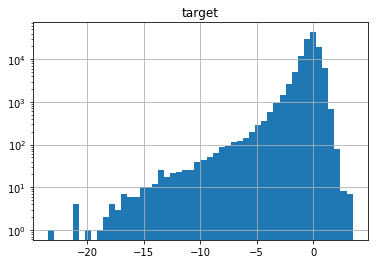

In [16]:
plt.figure()
df.hist(bins=50)
plt.yscale('log')


In [34]:
df_train[df_train.target<-20].shape[0]/df_train.shape[0]*100

1.0930233709890698

In [58]:
df.shape

(123623, 2)

In [56]:
df_changed=df.copy()


In [64]:
df_changed[df_changed.target<-17]

,card_id,target
5008,C_ID_be92f84f5c,-21.208025
7750,C_ID_a74b12dcf8,-23.452014
20556,C_ID_aae50409e7,-21.288833
25568,C_ID_767923bdb9,-18.258673
27982,C_ID_e7f772dfc0,-17.808302
32446,C_ID_ac114ef831,-19.902603
35851,C_ID_5ee52cf9f6,-17.461169
43215,C_ID_dc60219f6c,-17.628725
47616,C_ID_eccc654bc9,-18.994837
61601,C_ID_55f33eeda6,-17.520793


In [65]:
index=df_changed[df_changed.target<-17].index

In [66]:
df_changed.loc[index,'target']=-33.219281

In [67]:
df_changed.to_csv('chau_feature_engineering_3_date_manual_outliers.csv',index=False)